# Voltage divider bridge

## Import and Formatting

The goal of this section is to import all the necessary files and libraries required for the subsequent data analysis.  
It also includes setting up the formatting parameters for the plots and visualizations.

### Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from PySpice.Spice.Netlist import (
    Circuit, SubCircuitFactory
)
from PySpice.Unit import *
from PySpice.Spice.Library import SpiceLibrary

### Formatting

Adjusting Plotly chart settings for clarity and consistency.

In [2]:
# ----  Formatting charts
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['axes.edgecolor']  = "#bcbcbc"
mpl.rcParams['patch.linewidth'] = 0.5
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['axes.facecolor']  = "#eeeeee"
mpl.rcParams['axes.labelsize']  = "large"
mpl.rcParams['axes.grid']       = True
mpl.rcParams['grid.linestyle']  = "--"
mpl.rcParams['patch.edgecolor'] = "#eeeeee"
mpl.rcParams['axes.titlesize']  = "x-large"

## Introcution

L'objectif d'un pond diviseur de tension est relativement simple, il a pour objectif de réduire la tension entre l'entrée et la sortie. C'est le circuit le plus simple. Il est utiliser dans un certain nombre de circuit, mais il faut bien savoir les limites de se type de montage.

## Circuit

The circuit is shown in [Figure](#circuit-electrique-pond-diviseur-tension).
It is a relatively simple configuration composed of two resistors connected **in series**.
The **input voltage** is applied across both resistors, while the **output voltage** is measured **between** them.

```{figure} ./images/pond_diviseur_tension.svg
:name: circuit-electrique-pond-diviseur-tension
:align: center
:width: 500px

Voltage Divider Circuit
```

## Equation (circuit without charge)

The output voltage is given by the following equation:

$$U_2 = U \cdot \frac{R_2}{R_1 + R_2}$$

The derivation of this formula is shown below:

```{dropdown} Voltage Divider Derivation
The goal is to determine the voltage across the resistor $R_2$.

We start by applying **Kirchhoff’s Voltage Law (KVL)**:

$$U = U_{R1} + U_{R2}$$  
$$U = R_1 \cdot i + R_2 \cdot i$$

From Ohm’s Law, we know that:

$$i = \frac{U_{R2}}{R_2}$$

Substituting this expression for the current into the previous equation gives:

$$U = R_1 \cdot \frac{U_{R2}}{R_2} + R_2 \cdot \frac{U_{R2}}{R_2}$$  
$$U = (R_1 + R_2) \cdot \frac{U_{R2}}{R_2}$$  
$$\frac{U_{R2}}{R_2} = U \cdot \frac{1}{R_1 + R_2}$$  
$$U_{R2} = U \cdot \frac{R_2}{R_1 + R_2}$$
```

## Simulation (Circuit Without Modification)

The objective of this section is to **verify the previously derived equations**.
As a first step, we will **implement the circuit in SPICE** to perform the simulation.

In [37]:
# ------------------------------------------------------------
# Circuit Creation
# ------------------------------------------------------------
circuit = Circuit('Voltage Divider')

# Input voltage source (10 V DC)
circuit.V('input', 'inp', circuit.gnd, 10@u_V)

# Resistor network
circuit.R('1', 'inp', 'out', 10@u_kOhm)   # R1 = 10 kΩ
circuit.R('2', 'out', circuit.gnd, 1@u_kOhm)  # R2 = 1 kΩ

# ------------------------------------------------------------
# Display Circuit Netlist
# ------------------------------------------------------------
print(circuit)

# ============================================================
# End of Circuit Definition
# ============================================================

.title Voltage Divider
Vinput inp 0 10V
R1 inp out 10kOhm
R2 out 0 1kOhm



In [38]:
# ============================================================
# Operating Point Simulation
# ============================================================

# ------------------------------------------------------------
# Initialize the Circuit Simulator
# ------------------------------------------------------------
simulator = circuit.simulator(
    temperature=25,             # Operating temperature [°C]
    nominal_temperature=25      # Nominal temperature [°C]
)

# ------------------------------------------------------------
# Run Operating Point Analysis
# ------------------------------------------------------------
analysis = simulator.operating_point()

# ------------------------------------------------------------
# Display Simulator Information
# ------------------------------------------------------------
print(simulator)

# ============================================================
# End of Operating Point Simulation
# ============================================================

.title Voltage Divider
Vinput inp 0 10V
R1 inp out 10kOhm
R2 out 0 1kOhm
.options TEMP = 25C
.options TNOM = 25C
.end



In [39]:
# ============================================================
# Display Output Voltage
# ============================================================

# ------------------------------------------------------------
# Extract and Display the Output Voltage
# ------------------------------------------------------------
U_out = float(analysis.out[0])
print(f"Output Voltage U_out = {U_out:.3f} V")

# ============================================================
# End of Output Display
# ============================================================

Output Voltage U_out = 0.909 V


We can observe that the **output signal** perfectly matches our expectations.
With a resistance $R_1 = 10,\text{k}\Omega$, $R_2 = 1,\text{k}\Omega$, and an input voltage of $10 \text{V}$, we obtain the following calculation:

$$
U_{out} = 10 \cdot \frac{1}{10 + 1} = 0.909,\text{V}
$$

This value is consistent with the simulation results.
Now, the objective is to analyze the **sensitivity of the system**.

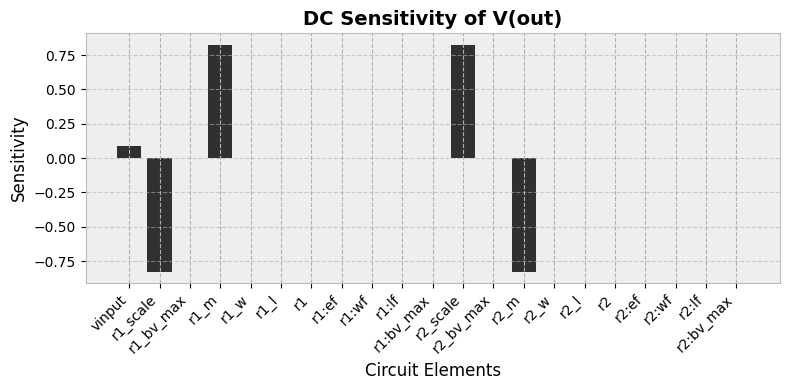

In [40]:
# ============================================================
# DC Sensitivity Analysis
# ============================================================

# ------------------------------------------------------------
# Perform DC Sensitivity Analysis
# ------------------------------------------------------------
analysis = simulator.dc_sensitivity('v(out)')

# ------------------------------------------------------------
# Extract Results
# ------------------------------------------------------------
labels = []
values = []

for element in analysis.elements.values():
    labels.append(str(element))
    values.append(float(element[0]))

# ------------------------------------------------------------
# Plot DC Sensitivity Results
# ------------------------------------------------------------
plt.figure(figsize=(8, 4))
plt.bar(labels, values, color='black', alpha=0.8)
plt.title('DC Sensitivity of V(out)', fontsize=14, weight='bold')
plt.xlabel('Circuit Elements', fontsize=12)
plt.ylabel('Sensitivity', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ============================================================
# End of DC Sensitivity Analysis
# ============================================================

It can be observed that there are **three main factors** influencing the system’s output.
The first is the **input voltage**. When the input voltage varies, the output voltage also changes. However, the objective of a **voltage regulator** is precisely to avoid this effect — maintaining a constant output regardless of input fluctuations.

The **second** and **third** influencing factors are related to the parameters *R1_scale*, *R2_scale*, *r1_m*, and *r2_m*.

Although these parameters are not identical, they are closely related. The table below summarizes their meaning:

| Name       | Meaning                  | Explanation            |
| ---------- | ------------------------ | ---------------------- |
| `R1_scale` | **Scaling factor parameter** of R1  | Represents the sensitivity of the output voltage when R1 is multiplied by a given factor (e.g., 1.01 for a +1% variation).  |
| `r1_m`     | **Direct sensitivity** of the resistance R1 model | Indicates the absolute (non-normalized) variation of ( V_{out} ) when R1 changes slightly. This is often used internally to normalize results. |

In conclusion, our system is **not stable**.
Even a small variation in resistance — for instance, due to **temperature changes** — can significantly alter the output voltage. Another important point is that the circuit contains **only resistive elements**, which means that **a portion of the input energy is dissipated as heat** within the resistors.

## Equation (Voltage Divider Circuit with Load)

So far, we have only analyzed our circuit without considering any external load. However, an important question arises: **does our output circuit have an output resistance?**
As shown in [](#bloc_pond_diviseur_tension):

```{figure} ./images/bloc.svg
:name: bloc_pond_diviseur_tension
:align: center
:width: 500px

Block diagram of a voltage divider
```

To model this behavior, we add a **load resistance** $R_L$ in parallel with $R_2$, as shown in [](#circuit-electrique-pond-diviseur-tension-avec-charge).

```{figure} ./images/Pont_divisuer_tension_charge.svg
:name: circuit-electrique-pond-diviseur-tension-avec-charge
:align: center
:width: 500px

Voltage Divider Circuit with Load
```

The equation of the new circuit is given by:

$$
U_2 = U \frac{R_2 R_L}{R_1 R_2 + R_1 R_L + R_2 R_L}
$$

```{dropdown} Voltage Divider Derivation
To derive this expression, note that the resistors $R_2$ and $R_L$ are connected in parallel.  
Their equivalent resistance is:

$$
R_{eq} = \frac{R_2 \cdot R_L}{R_2 + R_L}
$$

We can then reuse the equation obtained earlier for the unloaded voltage divider and replace \( R_2 \) with \( R_{eq} \):

$$
U_2 = U \frac{R_{eq}}{R_1 + R_{eq}}
$$

Substituting \( R_{eq} \) gives:

$$
U_2 = U \frac{\frac{R_2 \cdot R_L}{R_2 + R_L}}{R_1 + \frac{R_2 \cdot R_L}{R_2 + R_L}}
$$

Simplifying the expression:

$$
U_2 = U \frac{\frac{R_2 \cdot R_L}{R_2 + R_L}}{\frac{R_1 R_2 + R_1 R_L + R_2 R_L}{R_2 + R_L}}
$$

Finally, we obtain:

$$
U_2 = U \frac{R_2 \cdot R_L}{R_1 R_2 + R_1 R_L + R_2 R_L}
$$
```

## Simulation with charge

In [48]:
# ------------------------------------------------------------
# Circuit Creation
# ------------------------------------------------------------
circuit = Circuit('Voltage Divider with charge')

# Input voltage source (10 V DC)
circuit.V('input', 'inp', circuit.gnd, 10@u_V)

# Resistor network
circuit.R('1', 'inp', 'out', 10@u_kOhm)       # R1 = 10 kΩ
circuit.R('2', 'out', circuit.gnd, 1@u_kOhm)  # R2 = 1 kΩ

# ------------------------------------------------------------
# Display Circuit Netlist
# ------------------------------------------------------------
print(circuit)

# ============================================================
# End of Circuit Definition
# ============================================================

.title Voltage Divider with charge
Vinput inp 0 10V
R1 inp out 10kOhm
R2 out 0 1kOhm



In [50]:
# ------------------------------------------------------------
# Circuit Creation
# ------------------------------------------------------------
base_circuit = Circuit('Voltage Divider with Load')

# Fixed part of the circuit
base_circuit.V('input', 'inp', base_circuit.gnd, 10@u_V)
base_circuit.R('1', 'inp', 'out', 10@u_kOhm)  # R1 = 10 kΩ
base_circuit.R('2', 'out', base_circuit.gnd, 1@u_kOhm)  # R2 = 1 kΩ

# ------------------------------------------------------------
# Simulation setup
# ------------------------------------------------------------
RL_values = np.logspace(1, 6, 200)
Vout_values = []

for RL in RL_values:
    # Create a copy of the base circuit
    circuit = base_circuit.clone()
    
    # Add the load resistor for this iteration
    circuit.R('L', 'out', circuit.gnd, RL @ u_Ohm)
    
    # Run simulation
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.operating_point()

    # Read output voltage
    Vout = float(analysis.out[0])
    Vout_values.append(Vout)

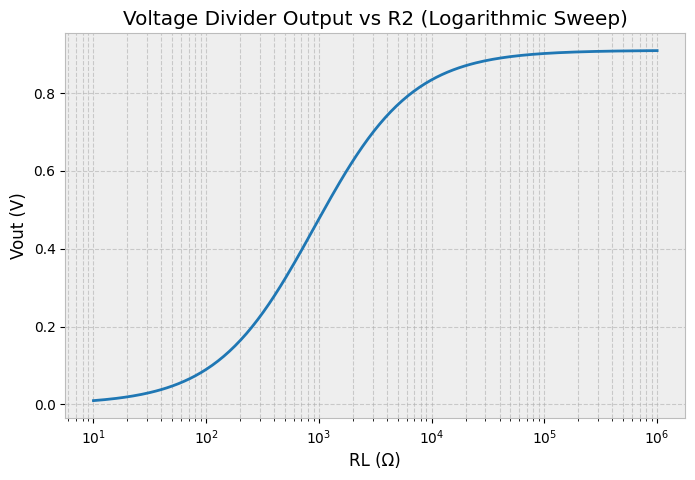

In [52]:
# ============================================================
# Plot Results
# ============================================================
plt.figure(figsize=(8, 5))
plt.semilogx(R2_values, Vout_values, lw=2)
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.title("Voltage Divider Output vs R2 (Logarithmic Sweep)")
plt.xlabel("RL (Ω)")
plt.ylabel("Vout (V)")
plt.show()

The previous graph highlights several important points. First, it clearly illustrates the importance of having a **very high load resistance** compared to the resistor in the voltage divider. To ensure that the output voltage is not significantly affected, it is necessary that:

$$
R_L \gg R_2
$$

In other words, the load resistance $R_L$ must be **much larger than the resistor $R_2$** to minimize the loading effect on the output voltage.

The **voltage divider** is a very simple circuit made of two resistors in series. The output voltage is taken between the two resistors and depends on their ratio. This circuit is used to reduce or adjust a voltage to a desired level. For example, if an input voltage $V_\text{in}$ is applied to a divider with resistors $R_1$ and $R_2$, the output voltage $V_\text{out}$ is given by:

$$
V_\text{out} = V_\text{in} \cdot \frac{R_2}{R_1 + R_2}
$$

Although this configuration is simple and effective for certain applications, it has limitations, especially when used as a voltage regulator:

**Advantages:**

* Simple and very low cost.
* Easy to design for approximate voltage levels.
* Ideal for very low current loads or voltage measurements.

**Disadvantages:**

* The output voltage depends directly on the load: if the load current changes, the output voltage changes.
* Inefficient for supplying significant currents without modifying the circuit.
* Any variations in temperature or resistor values can affect the output voltage.
* Does not protect against overvoltage or input voltage fluctuations.

In conclusion, a voltage divider is **ideal for static applications or low-current measurements**, but it is **not suitable as a reliable voltage regulator** when a constant voltage is required for varying loads.